In [1]:
import scipy.misc
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from collections import namedtuple
from moviepy.editor import VideoFileClip
from functools import partial


model_dir='./runs/models/'
segmentation_model  = os.path.join(model_dir, 'optimized_graph.pb')
print(segmentation_model)


Label = namedtuple('Label', ['name', 'color'])

label_defs = [
    Label('unlabeled',     (0,     0,   0)),
    Label('dynamic',       (111,  74,   0)),
    Label('ground',        ( 81,   0,  81)),
    Label('road',          (128,  64, 128)),
    Label('sidewalk',      (244,  35, 232)),
    Label('parking',       (250, 170, 160)),
    Label('rail track',    (230, 150, 140)),
    Label('building',      ( 70,  70,  70)),
    Label('wall',          (102, 102, 156)),
    Label('fence',         (190, 153, 153)),
    Label('guard rail',    (180, 165, 180)),
    Label('bridge',        (150, 100, 100)),
    Label('tunnel',        (150, 120,  90)),
    Label('pole',          (153, 153, 153)),
    Label('traffic light', (250, 170,  30)),
    Label('traffic sign',  (220, 220,   0)),
    Label('vegetation',    (107, 142,  35)),
    Label('terrain',       (152, 251, 152)),
    Label('sky',           ( 70, 130, 180)),
    Label('person',        (220,  20,  60)),
    Label('rider',         (255,   0,   0)),
    Label('car',           (  0,   0, 142)),
    Label('truck',         (  0,   0,  70)),
    Label('bus',           (  0,  60, 100)),
    Label('caravan',       (  0,   0,  90)),
    Label('trailer',       (  0,   0, 110)),
    Label('train',         (  0,  80, 100)),
    Label('motorcycle',    (  0,   0, 230)),
    Label('bicycle',       (119, 11, 32))]

# with tf.gfile.GFile('graph_optimized.pb', 'rb') as f:
#    graph_def_optimized = tf.GraphDef()
#    graph_def_optimized.ParseFromString(f.read())

G = tf.Graph()
class SSeg(object):
    def __init__(self):
        #TODO load classifier

        self.graph=tf.Graph()

        with self.graph.as_default():
            od_graph_def= tf.GraphDef()
            with tf.gfile.GFile(segmentation_model,'rb') as fid:

                od_graph_def.ParseFromString(fid.read())
                tf.import_graph_def(od_graph_def, name='')

            self.image_tensor=self.graph.get_tensor_by_name('image_input:0')
            self.keep_prob=self.graph.get_tensor_by_name('keep_prob:0')
            self.out=self.graph.get_tensor_by_name('Softmax:0')

            self.sess= tf.Session(graph=self.graph)
            self.softmax_output = tf.nn.softmax(self.out)
            self.predictions_argmax = tf.argmax(self.softmax_output, axis=-1)
            

    def prediction_image(self,image):
        
        
        image_shape=(256, 512)
        label_colors = {i: np.array(l.color) for i, l in enumerate(label_defs)}

        image = scipy.misc.imresize(image, image_shape)
        t1=time.time()
        labels = self.sess.run([self.predictions_argmax], feed_dict={self.image_tensor: [image], self.keep_prob: 1})
        t2=time.time()
#         print('time= ', t2-t1)
    #     labels = sess.run(
    #         [tf.nn.softmax(logits)],
    #         {keep_prob: 1.0, input_image: [image]})
    #     print(labels.shape)

        labels = labels[0].reshape(image_shape[0], image_shape[1])
#         labels = labels[0][:, 1].reshape(image_shape[0], image_shape[1])

    #     segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        labels_colored = np.zeros((image_shape[0], image_shape[1], 4))  # 4 for RGBA
        for label in label_colors:
            label_mask = labels == label
            labels_colored[label_mask] = np.array((*label_colors[label], 127))
    #     mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))

        mask = scipy.misc.toimage(labels_colored, mode="RGBA")
#         plt.imshow(mask)
#         plt.show()
        street_im = scipy.misc.toimage(image)
        street_im.paste(mask, box=None, mask=mask)


        return np.array(street_im)



            



/home/surjith/miniconda3/envs/carnd-term1-newgpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


./runs/models/optimized_graph.pb


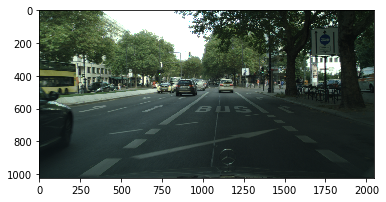

In [ ]:
segmen=SSeg()
image_pred = scipy.misc.imread("./data/test.png")
plt.imshow(image_pred)
plt.show()
img_out= segmen.prediction_image(image_pred)
plt.imshow(img_out)
plt.show()


video_input1='./data/project_video.mp4'
video_output1='result1.mp4'

video_input2='./data/challenge_video.mp4'
video_output2='result2.mp4'

video_input3='./data/harder_challenge_video.mp4'
video_output3='result3.mp4'

partial_process_image = partial(segmen.prediction_image)
clip1 = VideoFileClip(video_input1)
video_clip = clip1.fl_image(partial_process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output1, audio=False)

clip2 = VideoFileClip(video_input2)
video_clip = clip2.fl_image(partial_process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output2, audio=False)

clip3 = VideoFileClip(video_input3)
video_clip = clip3.fl_image(partial_process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output3, audio=False)